c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packag

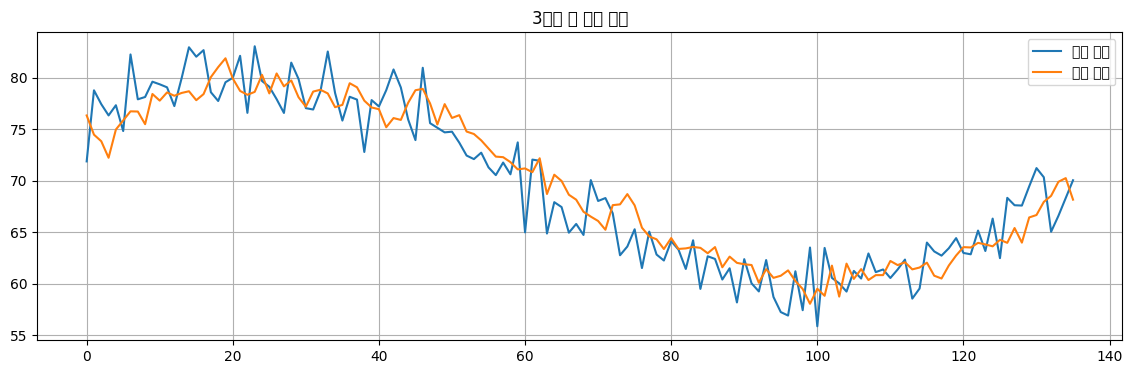

c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mingyu\AppData\Local\Programs\Python\Python313\Lib\site-p

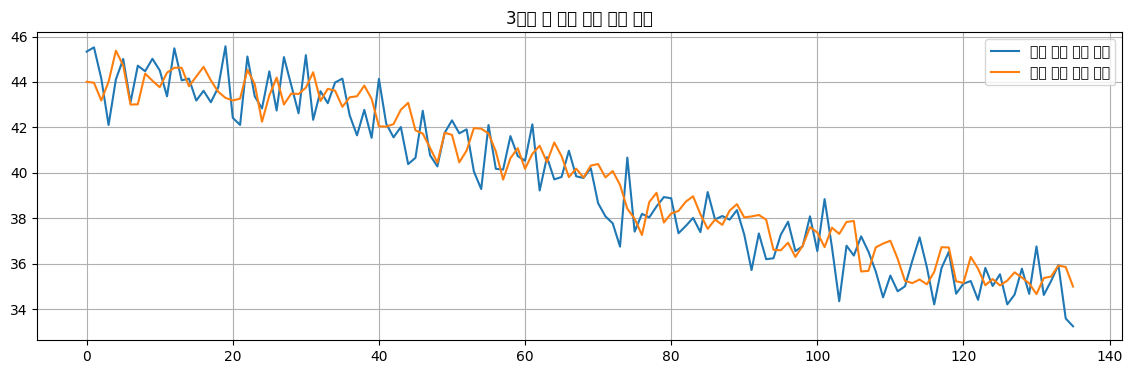

(np.float64(2.6235953071078173), np.float64(1.2141048969408836))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SCADA 데이터 불러오기
df = pd.read_excel("칠곡_데이터2.xlsx")

# 컬럼명 정리 및 datetime 처리
df.rename(columns={
    '기온(°C)': 'temp',
    '풍향(deg)': 'wind_dir',
    '풍속(m/s)': 'wind_speed',
    '현지기압(hPa)': 'pressure',
    '습도(%)': 'humidity'
}, inplace=True)

df['datetime'] = pd.to_datetime(df['일시'])
df = df.set_index('datetime')
df = df.sort_index()

# 유압/코일 평균 온도 컬럼 확인 및 파생 변수 생성
if '유압' not in df.columns or '코일평균온도' not in df.columns:
    # SCADA 데이터가 없으면 임의 생성
    np.random.seed(42)
    df['유압'] = 70 + 10 * np.sin(np.linspace(0, 10 * np.pi, len(df))) + np.random.normal(0, 2, len(df))
    df['코일평균온도'] = 40 + 5 * np.cos(np.linspace(0, 5 * np.pi, len(df))) + np.random.normal(0, 1, len(df))

# 타겟 생성 (3시간 후 예측)
PRED_H = 3
df['유압_t+3h'] = df['유압'].shift(-PRED_H)
df['코일온도_t+3h'] = df['코일평균온도'].shift(-PRED_H)
df.dropna(inplace=True)

# 시계열 예측용 feature 생성 (이동 평균 및 변화량)
df['유압_ma3'] = df['유압'].rolling(window=3).mean()
df['코일온도_diff'] = df['코일평균온도'].diff()
df.dropna(inplace=True)

# feature/target 분리
features = ['유압', '유압_ma3', '코일평균온도', '코일온도_diff']
X = df[features]
y1 = df['유압_t+3h']
y2 = df['코일온도_t+3h']

# 학습/테스트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, shuffle=False, test_size=0.2)
_, _, y2_train, y2_test = train_test_split(X, y2, shuffle=False, test_size=0.2)

# 모델 학습 (LGBM 대신 단순 시계열 기반 모델 활용 가능)
from sklearn.linear_model import Ridge
model_y1 = Ridge()
model_y2 = Ridge()

model_y1.fit(X_train, y1_train)
model_y2.fit(X_train, y2_train)

# 예측 및 평가
from sklearn.metrics import mean_squared_error
y1_pred = model_y1.predict(X_test)
y2_pred = model_y2.predict(X_test)

rmse_y1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
rmse_y2 = np.sqrt(mean_squared_error(y2_test, y2_pred))

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
plt.plot(y1_test.values, label='실제 유압')
plt.plot(y1_pred, label='예측 유압')
plt.title("3시간 후 유압 예측")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y2_test.values, label='실제 코일 평균 온도')
plt.plot(y2_pred, label='예측 코일 평균 온도')
plt.title("3시간 후 코일 평균 온도 예측")
plt.legend()
plt.grid()
plt.show()

rmse_y1, rmse_y2
